## Apply depthwise separable conv
This notebook replaces the ordinary conv in U-Net with Depthwise-separable conv and compares the performance when with/without this replacement.<br>
- The original `UNet` has **28957716** parameters and is aroud 7.4 times bigger than `UNet_dw`, which has **3925816** parameters.<br>
- Under the same conditions, training `UNet_dw` is around 18% faster than traing `UNet`.<br>
- Because of its depthwise separable conv, `UNet_dw` becomes deeper, produces more intermediate variables and requires more cuda memory.<br>

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from torchvision import datasets, models, transforms
from torchvision.transforms import ToPILImage
import torchvision.transforms.functional as tf
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from PIL import Image
from torch.utils import data
import time
import math
import os
import copy
import json
import random

In [3]:
colors = [
    0,   0,   0,
    128,   0,   0,   # Hat
    0, 128,   0,     # Hair
    128, 128,   0,   # Glove
    0,   0, 128,     # Sunglasses
    128,   0, 128,   # UpperClothes
    0, 128, 128,     # Dress
    128, 128, 128,   # Coat
    64,   0,   0,    # Socks
    192,   0,   0,   # Pants
    64, 128,   0,    # Jumpsuits
    192, 128,   0,   # Scarf
    64,   0, 128,    # Skirt
    192,   0, 128,   # Face
    64, 128, 128,    # Left-arm
    192, 128, 128,   # Right-arm
    0,  64,   0,     # Left-leg
    128,  64,   0,   # Right-leg
    0, 192,   0,     # Left-shoe
    128, 192,   0    # Right-shoe
]

In [4]:
def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True


def get_parameter_number(net):
    total_num = sum(p.numel() for p in net.parameters())
    trainable_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print('Total',total_num)
    print('Trainable',trainable_num)

In [5]:
def pad_to_square(img):
    s = img.size
    w = abs((s[0]-max(s))//2)
    h = abs((s[1]-max(s))//2)
    padding = (w,h,max(s)-s[0]-w,max(s)-s[1]-h)
    return tf.pad(img, padding)

In [6]:
def Train_transform(image,mask,flip=True):
    image = pad_to_square(image)
    mask = pad_to_square(mask)
    image = tf.resize(image, (224,224))
    mask = tf.resize(mask, (224,224))
    
    if flip==True:
        if random.random() > 0.5:
            image = tf.hflip(image)
            mask = tf.hflip(mask)
    
    image = tf.to_tensor(image)
    mask = np.array(mask)
    mask = torch.as_tensor(mask, dtype=torch.int64)
    image = tf.normalize(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return image, mask

def Other_transform(image,mask):
    return Train_transform(image,mask,False)

data_transform = {'train': Train_transform, 'eval': Other_transform, 'test': Other_transform}

In [7]:
class LIPDataset(data.Dataset):
    
    def __init__(self, root=None, img_path=None, mask_path=None, num_images=300, transform=None, start=0):   
        
        self.root = root
        self.img_path = img_path
        self.mask_path = mask_path
        self.transform = transform        
        self.images = []
        self.masks = []
        c = 0
        for step,name in enumerate(list(sorted(os.listdir(os.path.join(root,img_path))))):
            if step < start:
                continue
                
            if c == num_images:
                break
            im = os.path.join(root,img_path,name)
            ma = os.path.join(root,mask_path,name[:-4]+'.png')
            if self.is_valid_image(im) and self.is_valid_image(ma):
                self.images.append(im)
                self.masks.append(ma)
                c+=1
            else:
                print('img and mask failed to be opened:')
                print(im)
                print(ma)
        
    def is_valid_image(self, path):
        try:
            i = Image.open(path)
            valid = True
        except:
            valid = False
        return valid
        
    def __getitem__(self, idx):
        
        image = Image.open(self.images[idx]).convert('RGB')
        mask = Image.open(self.masks[idx])
        if self.transform:
            image, mask = self.transform(image,mask)
        return image, mask
   
    def __len__(self):
        return len(self.images)

In [8]:
def load_data(TRAIN_BS, num_train, num_eval):
    data_dir = {'root': '/kaggle/input/singleperson', 
                'train': ('TrainVal_images/TrainVal_images/train_images',
                          'TrainVal_parsing_annotations/TrainVal_parsing_annotations/TrainVal_parsing_annotations/train_segmentations',
                          num_train),
                'eval': ('TrainVal_images/TrainVal_images/val_images',
                         'TrainVal_parsing_annotations/TrainVal_parsing_annotations/TrainVal_parsing_annotations/val_segmentations',
                         num_eval)
               }
    datasets = {x: LIPDataset(data_dir['root'], data_dir[x][0], data_dir[x][1], 
                              data_dir[x][2], data_transform[x], start=data_dir[x][2]) for x in ['train', 'eval']}
    dataset_sizes = {x: len(datasets[x]) for x in ['train', 'eval']}
    print(dataset_sizes)
    dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=TRAIN_BS, 
                                                  shuffle=True, num_workers=2) for x in ['train','eval']}
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    return datasets, dataloaders, dataset_sizes, device

In [9]:
def imshow(phase):
    print(phase + ' images:')
    imshow_set = torch.utils.data.Subset(datasets[phase], np.arange(8))
    imshow_loader= torch.utils.data.DataLoader(imshow_set, batch_size=8, shuffle=False)
    imgs, masks = next(iter(imshow_loader))
    im = torchvision.utils.make_grid(imgs, nrow=4)
    im = im.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im = std * im + mean
    plt.imshow(im)
    plt.pause(0.001)
    
    ma = torch.unsqueeze(masks,1)
    ma = torchvision.utils.make_grid(ma, nrow=4)
    ma = ma.numpy().transpose((1, 2, 0))
    ma = ma / 20
    plt.imshow(ma)
    plt.pause(0.001)

### U-Net with depthwise conv

In [10]:
def conv_dw(ch_in, ch_out):
    return nn.Sequential(
            nn.Conv2d(ch_in, ch_in, kernel_size=3, stride=1, padding=1, groups=ch_in, bias=True),
            nn.BatchNorm2d(ch_in),
            nn.ReLU(inplace=True),

            nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

class conv_x_2(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_x_2,self).__init__()
        self.conv1 = conv_dw(ch_in, ch_out)
        self.conv2 = conv_dw(ch_out, ch_out)
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.up(x)
        return x

    
class UNet_dw(nn.Module):
    def __init__(self):
        super(UNet_dw,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_x_2(ch_in=3,ch_out=64)
        self.Conv2 = conv_x_2(ch_in=64,ch_out=128)
        self.Conv3 = conv_x_2(ch_in=128,ch_out=256)
        self.Conv4 = conv_x_2(ch_in=256,ch_out=512)
        self.Conv5 = conv_x_2(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_x_2(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_x_2(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_x_2(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_x_2(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,20,kernel_size=1,stride=1,padding=0)
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

    
    def forward(self,x):
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

### ordinary U-Net

In [11]:
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.conv(x)
        return x

    
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        x = self.up(x)
        return x

    
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=3,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,20,kernel_size=1,stride=1,padding=0)
        

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)

    
    def forward(self,x):
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [12]:
def mIoU(output, target, smooth=1):
    output = output.cpu().detach()
    output = torch.softmax(output,dim=1)
    _, pred = torch.max(output,dim=1)
    assert pred.size() == target.size()
    pred = pred.view(-1)
    target = target.cpu().detach().view(-1)      
    accs=np.zeros(20)
    for i in range(20):        
        pred_c = pred==i
        target_c = target==i
        intersection = (pred_c * target_c).sum().numpy()
        union = (pred_c + target_c).sum().numpy()
        accs[i] = (intersection + smooth)/(union + smooth)
    return accs


def train_model(model, criterion, optimizer, num_epochs, scheduler=None):
    since = time.time()
    
    statistics = {'train':([],[]), 'eval':([],[])} # train:(loss,acc), test:(loss,acc)
    lrs = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    iters = len(dataloaders['train'])
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_accs = np.zeros(20)
                      
            for step,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        lrs.append((step, optimizer.param_groups[0]['lr']))
                        loss.backward()
                        optimizer.step()
                        if scheduler is not None:
                            scheduler.step(epoch + step / iters)
                        
                running_loss += loss.item() * inputs.size(0)
                running_accs += mIoU(outputs, labels) * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = np.mean(running_accs / dataset_sizes[phase])

            statistics[phase][0].append(epoch_loss)
            statistics[phase][1].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))
    
    return model, statistics, lrs, outputs

In [13]:
def visualize_accuracy(num_epochs, statistics, fig_name):
    sns.set(style="white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
    for phase,(loss,acc) in statistics.items():
        loss_hist = [float(h) for h in loss]
        acc_hist = [float(h) for h in acc]
        ax1.plot(np.arange(len(loss_hist)), loss_hist, label = phase)
        ax1.set(xlabel = 'Epochs', ylabel='loss',title='loss at the xth epoch');
        ax1.legend();
        ax2.plot(np.arange(len(acc_hist)), acc_hist, label = phase)
        ax2.set(xlabel = 'Epochs', ylabel='accuracy',title='accuracy at the xth epoch');
        ax2.legend();
    fig.show()
    fig.savefig(fig_name)

{'train': 1600, 'eval': 160}
cuda:0
Total 3925816
Trainable 3925816
Epoch 0/9
----------
train Loss: 1.4321 Acc: 0.0437
eval Loss: 1.0051 Acc: 0.0522

Epoch 1/9
----------
train Loss: 1.0262 Acc: 0.0516
eval Loss: 0.9096 Acc: 0.0577

Epoch 2/9
----------
train Loss: 0.9757 Acc: 0.0640
eval Loss: 0.9407 Acc: 0.0700

Epoch 3/9
----------
train Loss: 0.9434 Acc: 0.0781
eval Loss: 0.8864 Acc: 0.0778

Epoch 4/9
----------
train Loss: 0.9111 Acc: 0.0872
eval Loss: 0.8048 Acc: 0.0909

Epoch 5/9
----------
train Loss: 0.8762 Acc: 0.0961
eval Loss: 0.8056 Acc: 0.0874

Epoch 6/9
----------
train Loss: 0.8565 Acc: 0.1010
eval Loss: 0.7787 Acc: 0.1027

Epoch 7/9
----------
train Loss: 0.8333 Acc: 0.1098
eval Loss: 0.8288 Acc: 0.1132

Epoch 8/9
----------
train Loss: 0.8087 Acc: 0.1160
eval Loss: 0.8176 Acc: 0.1093

Epoch 9/9
----------
train Loss: 0.7964 Acc: 0.1183
eval Loss: 0.7374 Acc: 0.1047

Training complete in 17m 6s
Best eval Acc: 0.113191


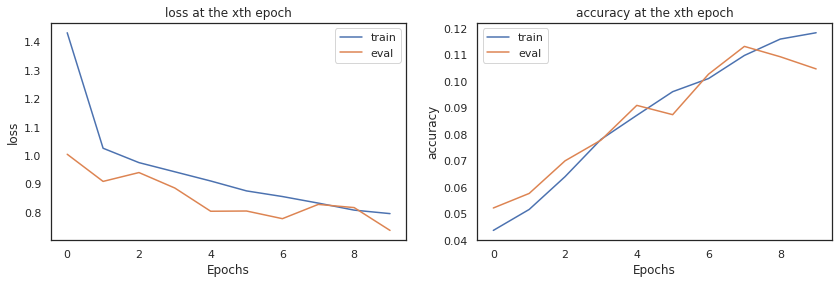

In [14]:
setup_seed(20)
datasets, dataloaders, dataset_sizes, device = load_data(16,1600,160)

model = UNet_dw()
model = model.to(device)
get_parameter_number(model)
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
model, statistics, lrs, outputs = train_model(model, criterion, optimizer, num_epochs=num_epochs, scheduler=None)
visualize_accuracy(num_epochs, statistics, 'UNdw.png')

{'train': 1600, 'eval': 160}
cuda:0
Total 28957716
Trainable 28957716
Epoch 0/9
----------
train Loss: 1.2036 Acc: 0.0474
eval Loss: 0.9782 Acc: 0.0508

Epoch 1/9
----------
train Loss: 0.9874 Acc: 0.0595
eval Loss: 0.9214 Acc: 0.0592

Epoch 2/9
----------
train Loss: 0.9545 Acc: 0.0677
eval Loss: 0.9786 Acc: 0.0699

Epoch 3/9
----------
train Loss: 0.9337 Acc: 0.0743
eval Loss: 0.8918 Acc: 0.0721

Epoch 4/9
----------
train Loss: 0.9156 Acc: 0.0812
eval Loss: 0.9759 Acc: 0.0608

Epoch 5/9
----------
train Loss: 0.9058 Acc: 0.0838
eval Loss: 1.1972 Acc: 0.0734

Epoch 6/9
----------
train Loss: 0.8907 Acc: 0.0886
eval Loss: 1.2681 Acc: 0.0654

Epoch 7/9
----------
train Loss: 0.8784 Acc: 0.0921
eval Loss: 0.8102 Acc: 0.0970

Epoch 8/9
----------
train Loss: 0.8680 Acc: 0.0981
eval Loss: 1.1028 Acc: 0.0722

Epoch 9/9
----------
train Loss: 0.8622 Acc: 0.1014
eval Loss: 1.2235 Acc: 0.0881

Training complete in 20m 48s
Best eval Acc: 0.096983


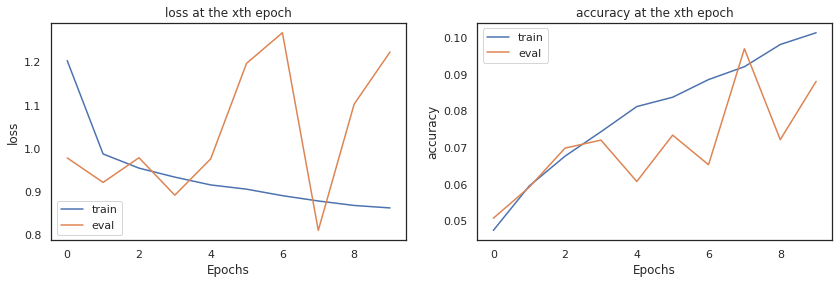

In [15]:
setup_seed(20)
datasets, dataloaders, dataset_sizes, device = load_data(16,1600,160)

model = UNet()
model = model.to(device)
get_parameter_number(model)
num_epochs = 10

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
model, statistics, lrs, outputs = train_model(model, criterion, optimizer, num_epochs=num_epochs, scheduler=None)
visualize_accuracy(num_epochs, statistics, 'UN.png')